# CIFAR10 classification using pre-trained ConvNet

## Problem overview
A given problem was the classification of images from the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

## Dataset
Quote from the CIFAR-10 website:
>The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

>The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Moreover, due to hardware limitations, only 10000 images were used for training (20% of training dataset).

## Downloading data
The dataset was downloaded as a .tar.gz file and extracted using a downloader script.

## Loading data
Data batch files consists of label vector and two-dimensional data array. Since the single batch file does not necessarily have an equal number of images from each class, two batch files were downloaded and then 1000 images from each class was randomly sampled.

In [2]:
import numpy as np
from sklearn.utils import shuffle

from utils.loader import load_cifar_10

X, y, X_test, y_test = load_cifar_10('./datasets/cifar-10-batches-py', number_of_batches=2)

train_size = 10000
val_size = 3000
num_classes = 10
Xs = []
ys = []
Xs_val = []
ys_val = []
for cls in range(num_classes):
    cls_idxs = np.flatnonzero(y == cls)
    train_idxs = np.random.choice(cls_idxs, train_size // num_classes, replace=False)
    Xs.append(X[train_idxs])
    ys.append(y[train_idxs])
    
    cls_idxs = np.setdiff1d(cls_idxs, train_idxs)
    val_idxs = train_idxs = np.random.choice(cls_idxs, val_size // num_classes, replace=False)
    Xs_val.append(X[val_idxs])
    ys_val.append(y[val_idxs])

X_train = np.concatenate(Xs)
y_train = np.concatenate(ys)
del Xs, ys
X_val = np.concatenate(Xs_val)
y_val = np.concatenate(ys_val)
del Xs_val, ys_val

print('Train set shape:', X_train.shape)
print('Validation set shape:', X_val.shape)
print('Test set shape:', X_test.shape)

X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)

Loaded trainset.
Loaded testset.
Train set shape: (10000, 32, 32, 3)
Validation set shape: (3000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


## Data visualization
Below are examples of images from each class of CIFAR-10 dataset.

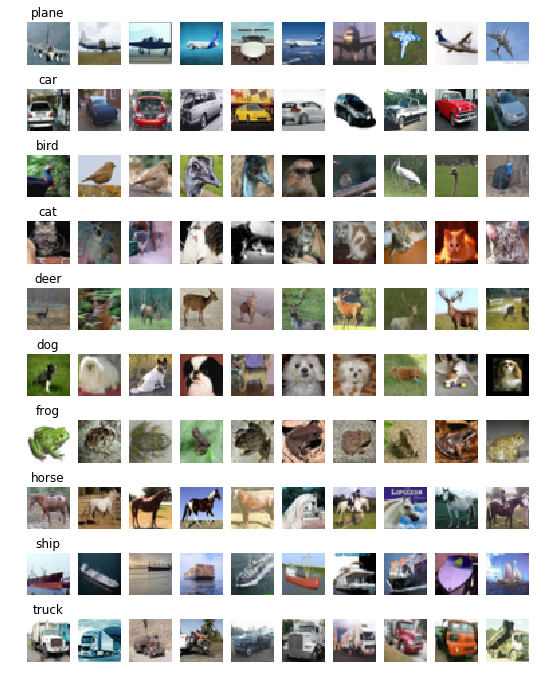

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 10
plt.subplots(figsize=(9, 12))
gs = GridSpec(num_classes, samples_per_class)
for cls, cls_name in enumerate(classes):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(gs[cls, i])
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

## Shallow classifier
The first step was to extract features using feature descriptor, in this case [Histogram of Oriented Gradients](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html) has been used. 
### HOG
For extracting was used implementation of HOG algorithm from scikit-image library. I used default parameters from hog function and optimal parameters from Dalal and Triggs human detection experiment.

In [5]:
from tqdm import tqdm

from features import extract_hog

# default skimage parameters
hog_params = {
    'orientations': 8,
    'pixels_per_cell': (16, 16),
    'cells_per_block': (1, 1)
}
X_train_hog_sk = np.array([extract_hog(X, **hog_params) for X in tqdm(X_train)])
X_val_hog_sk = np.array([extract_hog(X, **hog_params) for X in tqdm(X_val)])

# Dalal and Triggs parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2)
}
X_train_hog_dt = np.array([extract_hog(X, **hog_params) for X in tqdm(X_train)])
X_val_hog_dt = np.array([extract_hog(X, **hog_params) for X in tqdm(X_val)])

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1323.27it/s]


### SVM
For classification the [Support Vector Machine](http://scikit-learn.org/stable/modules/svm.html) algorithm with linear kernel has been used.

In [8]:
from sklearn.svm import LinearSVC

hog_svm_sk = LinearSVC(C=1.0)
hog_svm_sk.fit(X_train_hog_sk, y_train)
score = hog_svm_sk.score(X_val_hog_sk, y_val)
print(f'SVM with HOG features accuracy (skimage params): {score * 100:.2f}%')

hog_svm_dt = LinearSVC(C=1.0)
hog_svm_dt.fit(X_train_hog_dt, y_train)
score = hog_svm_dt.score(X_val_hog_dt, y_val)
print(f'SVM with HOG features accuracy (Dalal and Triggs params): {score * 100:.2f}%')

SVM with HOG features accuracy (skimage params): 30.30%
SVM with HOG features accuracy (Dalal and Triggs params): 49.30%


SVM trained on HOG descriptor with Dalal and Triggs params performed better than the first one, so this one has been tested on the test set to serve as a benchmark.

In [9]:
X_test_hog = np.array([extract_hog(X, **hog_params) for X in tqdm(X_test)])
score = hog_svm_dt.score(X_test_hog, y_test)
print(f'SVM with HoG features test accuracy (Dalal and Triggs params): {score * 100:.2f}%')

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1306.30it/s]


SVM with HoG features test accuracy (Dalal and Triggs params): 49.90%


# Deep Learning
The second approach was based on extracting features (CNN Codes) from pre-trained ConvNet and training on them a SVM classifier.
## Getting pre-trained model
Various models are available in keras.applications module. Table from official [Keras](https://keras.io/applications/) documentation, describing the parameters and results in IMAGENET competition, is presented below.

|Model|Size|Top-1 Accuracy|Top-5 Accuracy|Parameters|Depth|
|-----|----|--------------|--------------|----------|-----|
|Xception|88 MB|0.790|0.945|22,910,480|126|
|VGG16|528 MB|0.715|0.901|138,357,544|23|
|VGG19|549 MB|0.727|0.910|143,667,240|26|
|ResNet50|99 MB|0.759|0.929|25,636,712|168|
|**InceptionV3**|**92 MB**|**0.788**|**0.944**|**23,851,784**|**159**|
|InceptionResNetV2|215 MB|0.804|0.953|55,873,736|572|
|MobileNet|17 MB|0.665|0.871|4,253,864|88|
|DenseNet121|33 MB|0.745|0.918|8,062,504|121|
|DenseNet169|57 MB|0.759|0.928|14,307,880|169|
|DenseNet201|80 MB|0.770|0.933|20,242,984|201|

The best performance from all models has the InceptionResNetV2. However, due to large size and computing requirements I decided to use InceptionV3 model. One model extract features from second top layer (AveragePooling layer). Second model extract features from intermediate layer.

In [13]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, AveragePooling2D
from keras.models import Model
from keras import backend as K

def inception_v3_without_top_layer():
    tf_input = Input(shape=(299, 299, 3))
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def inception_v3_model_intermediate_layer():
    tf_input = Input(shape=(299, 299, 3))
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    intermediate_layer = model.get_layer('mixed7').output
    intermediate_pooled = AveragePooling2D((17, 17), strides=(17, 17))(intermediate_layer)
    return Model(model.input, intermediate_pooled)

Since images in CIFAR-10 dataset are 32 by 32 pixels, but input of InceptionV3 is 299 by 299 pixels, we have to resize images from our dataset. Also, before providing images to InceptionV3 input layer, it has to be preprocessed properly. 

In [14]:
batch_of_images_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))
tf_resize_op = tf.image.resize_images(batch_of_images_placeholder, (299, 299), method=0)

def data_gen(session, data, labels, batch_size):
    for i in range(0, len(labels), batch_size):
        resized_img_batch = session.run(tf_resize_op, {batch_of_images_placeholder: data[i:i + batch_size]})
        preprocessed_img_batch = preprocess_input(resized_img_batch)
        labels_batch = labels[i:i + batch_size]
        yield preprocessed_img_batch, labels_batch

Features was extracted from both models and saved in .npz files.

In [12]:
from features import extract_cnn_codes

# X_cnn_train_wtl = extract_cnn_codes(inception_v3_without_top_layer, X_train, y_train, data_gen)
# X_cnn_val_wtl = extract_cnn_codes(inception_v3_without_top_layer, X_val, y_val, data_gen)
# X_cnn_test_wtl = extract_cnn_codes(inception_v3_without_top_layer, X_test, y_test, data_gen)
# np.savez_compressed(
#     './features/inception_v3_without_top_layer.npz',
#     X_cnn_train=X_cnn_train_wtl,
#     X_cnn_val=X_cnn_val_wtl,
#     X_cnn_test=X_cnn_test_wtl,
#     y_cnn_train=y_train,
#     y_cnn_val=y_val,
#     y_cnn_test=y_test
# )

# X_cnn_train_il = extract_cnn_codes(inception_v3_model_intermediate_layer, X_train, y_train, data_gen)
# X_cnn_val_il = extract_cnn_codes(inception_v3_model_intermediate_layer, X_val, y_val, data_gen)
# X_cnn_test_il = extract_cnn_codes(inception_v3_model_intermediate_layer, X_test, y_test, data_gen)
# np.savez_compressed(
#     './features/inception_v3_model_intermediate_layer.npz',
#     X_cnn_train=X_cnn_train_il,
#     X_cnn_val=X_cnn_val_il,
#     X_cnn_test=X_cnn_test_il,
#     y_cnn_train=y_train,
#     y_cnn_val=y_val,
#     y_cnn_test=y_test
# )

wtl_codes = np.load('./features/inception_v3_without_top_layer.npz')
X_cnn_wtl_train = wtl_codes['X_cnn_train']
y_wtl_train = wtl_codes['y_cnn_train']
X_cnn_wtl_val = wtl_codes['X_cnn_val']
y_wtl_val = wtl_codes['y_cnn_val']

il_codes = np.load('./features/inception_v3_model_intermediate_layer.npz')
X_cnn_il_train = il_codes['X_cnn_train']
y_il_train = il_codes['y_cnn_train']
X_cnn_il_val = il_codes['X_cnn_val']
y_il_val = il_codes['y_cnn_val']

print(f'Without top layer CNN Codes shape: {X_cnn_wtl_train.shape}')
print(f'Intermediate layer CNN Codes shape: {X_cnn_il_train.shape}')

Without top layer CNN Codes shape: (10000, 1, 1, 2048)
Intermediate layer CNN Codes shape: (10000, 1, 1, 768)


In [13]:
X_cnn_wtl_train = X_cnn_wtl_train.reshape(-1, 2048)
X_cnn_wtl_val = X_cnn_wtl_val.reshape(-1, 2048)

X_cnn_il_train = X_cnn_il_train.reshape(-1, 768)
X_cnn_il_val = X_cnn_il_val.reshape(-1, 768)

In [15]:
from sklearn.svm import LinearSVC

cnn_wtl_svm = LinearSVC(C=1.0)
cnn_wtl_svm.fit(X_cnn_wtl_train, y_wtl_train)
score = cnn_wtl_svm.score(X_cnn_wtl_val, y_wtl_val)
print(f'SVM with CNN Codes (second top layer) accuracy: {score * 100:.2f}%')

cnn_il_svm = LinearSVC(C=1.0)
cnn_il_svm.fit(X_cnn_il_train, y_il_train)
score = cnn_il_svm.score(X_cnn_il_val, y_il_val)
print(f'SVM with CNN Codes (intermediate layer) accuracy: {score * 100:.2f}%')

SVM with CNN Codes (second top layer) accuracy: 82.47%
SVM with CNN Codes (intermediate layer) accuracy: 87.67%


Second model (outputing from intermediate layer) performed slighty better than the first one, so will be used in next validations.

## CNN Codes visualization
Then Principal Component Analysis was performed. I used [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) algorithm implementation from sklearn.decomposition module

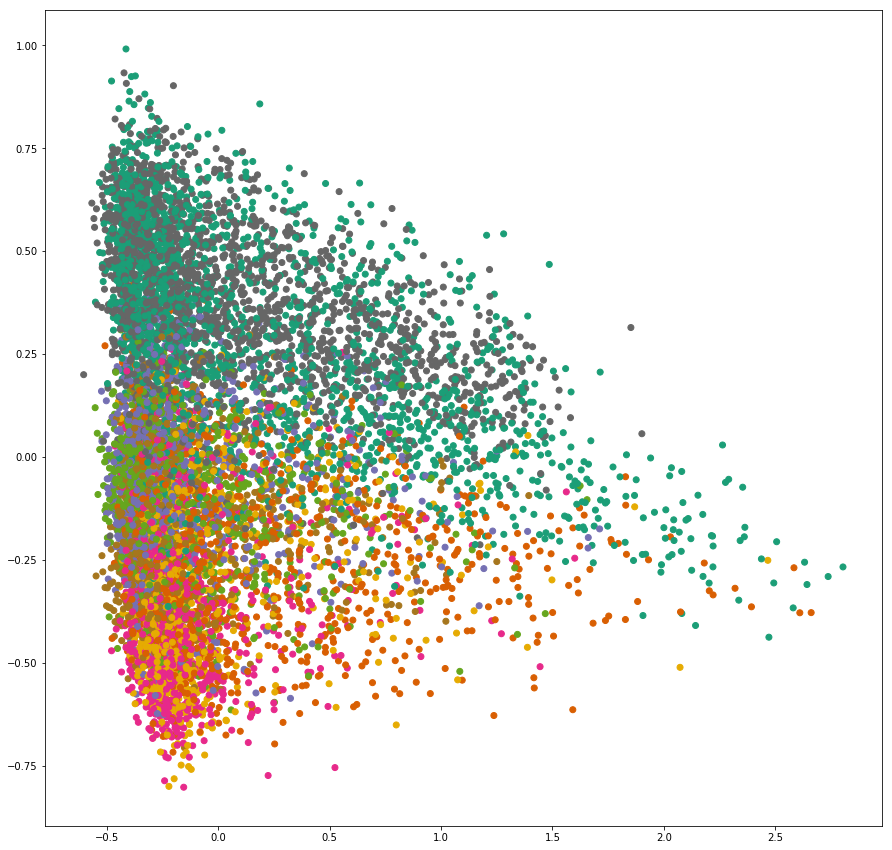

In [69]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(X_cnn_il_train)

X = pca.transform(X_cnn_il_train)
plt.figure(figsize=(15,15))
plt.scatter(X[:, 0], X[:, 1], c=y_il_train, cmap='Dark2')
plt.show()

## Training classifiers on top of CNN Codes
Lastly I trained various classifiers on reduced CNN Codes.

In [103]:
from sklearn.svm import LinearSVC

for c in [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]:
    cnn_svm_reduced = LinearSVC(C=c)
    cnn_svm_reduced.fit(X_cnn_il_train, y_il_train)
    score = cnn_svm_reduced.score(X_cnn_il_val, y_il_val)
    print(f'C: {c} accuracy: {score * 100:.2f}%')

C: 0.0001 accuracy: 64.93%
C: 0.001 accuracy: 73.80%
C: 0.01 accuracy: 83.10%
C: 0.1 accuracy: 87.30%
C: 0.5 accuracy: 87.93%
C: 1.0 accuracy: 87.67%
C: 1.5 accuracy: 87.87%
C: 2.0 accuracy: 87.53%
C: 5.0 accuracy: 87.20%
C: 10.0 accuracy: 86.73%


In [104]:
from sklearn.ensemble import BaggingClassifier

bg_clf = BaggingClassifier(base_estimator=LinearSVC(C=0.5), max_samples=0.5, max_features=0.5, n_estimators=10)
bg_clf.fit(X_cnn_il_train, y_il_train)
score = bg_clf.score(X_cnn_il_val, y_il_val)
print(f'BaggingClassifier accuracy: {score * 100:.2f}%')

BaggingClassifier accuracy: 86.90%


In [105]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', gamma=.000001, C=100000)
clf.fit(X_cnn_il_train, y_il_train)
score = clf.score(X_cnn_il_val, y_il_val)
print(f'SVM with CNN Codes accuracy: {score * 100:.2f}%')

SVM with CNN Codes accuracy: 86.70%


## Testing classifier

In [106]:
X_cnn_il_test = il_codes['X_cnn_test']
y_il_test = il_codes['y_cnn_test']
X_cnn_il_test = X_cnn_il_test.reshape(-1, 768)

classifier = LinearSVC(C=0.5)
classifier.fit(X_cnn_il_train, y_il_train)
score = classifier.score(X_cnn_il_test, y_il_test)
print(f'Classifier test accuracy: {score * 100:.2f}%')

Classifier test accuracy: 87.91%


## Final words
I finally managed to obtain a 87.91% score, which referring to [this page](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) places my final classifier in the middle of other solutions.